In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pickle
import math
import os
import warnings
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
sys.path.insert(1,'../code/data_utils/')
from HiCMap import HiCMap
sys.path.insert(1,'../code/data_utils/')
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')
warnings.filterwarnings('ignore')

#### User selections

Choose the folder where the plots should be saved. The Hi-C and distance plots will be placed into separate subdirectories (if desired). 

In [2]:
save_directory = './Fig1AddNoise/'
hic_subdir = 'hic_plots'
dist_subdir = 'dist_plots'

Information about the region to plot, the directory containing coordinate files, etc. 

In [3]:
data_dir = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/conformations/GM/'
milestone = 120
chrom = '21'
region_idx = 1000
guidance_strengths_reweightings_and_contributions = [(1.,0.,.5),(5.,8.,.5)]

specific_conformation_guidance_idx = 0 # Use the cond_scale=1, rescaled_phi=0 data for the individual conformation plots
specific_conformation_idx = 0          # Use the first generated conformation in that dataset for the individual conformation plots 

resolution = 20_000

Force recompute/recreation of plots even if files already exist? 

In [4]:
force_recompute = False
force_replot = False

Number of timesteps to use

In [5]:
num_timesteps = 1000

Function parameters for converting distances into contact probabilities

In [6]:
r_c=1.5
sigma=3.72
decay=3.45

Location of support files

In [7]:
rosetta_stone_fp = '../data/embeddings_64_after_transformer/rosetta_stone.pkl' # to convert between region indices and genomic indices
mcool_fp = '../data/outside/GM12878_hg19.mcool'

Perform computations on GPU if available (or change if that isn't the desired behavior)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

#### Support functions

Beta schedule. Simply using cosine schedule since that was used in the paper rather than generalizing the option. 

This function comes from the [lucidrains code on GitHub](https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/classifier_free_guidance.py) that we adopted/adapted for this paper. 

In [9]:
def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

Function to add noise in a forward-time diffusion trajectory

In [10]:
def forward_step(dists,beta):
    '''
    This assumes the passed dists instance is a Distances object. 
    To mimic what is done in ChromoGen, it then 
        1. folds the data into the two-channel representation
        1. normalizes the distances via procedure used in the paper;
        2. changes normalized range from [0,1] to [-1,1], as in the GaussianDiffusion class; 
        3. adds noise for a SINGLE timestep; and
        4. unnormalizes/unfolds data back into standard distance space.
    '''

    # 1
    dists = dists.normalize().fold()

    # 2
    dists._values*= 2
    dists._values-= 1

    # 3
    dists._values*= ( 1 - beta )**.5
    dists._values+= torch.randn_like(dists.values) * beta
    dists._values.clip_(-1,1)

    # 3b: Our 

    # 4
    dists._values+= 1
    dists._values/= 2
    dists.unfold_().unnormalize_()
    
    return dists

Full step across ALL conformations

In [11]:
def take_step(dists_dict,beta):

    new_dists_dict = {}
    for cond_scale,temp in dists_dict.items():
        new_dists_dict[cond_scale] = {}
        for rescaled_phi,temp1 in temp.items():
            # Add noise
            new_dists_dict[cond_scale][rescaled_phi] = {
                'dists':forward_step(temp1['dists'],beta),
                'contribution':temp1['contribution']
            }

    return new_dists_dict

Obtain Hi-C map

In [12]:
def to_hic(conformations,r_c=r_c,sigma=sigma,decay=decay):
    
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( 1 + ( sigma * (r_c - p[mask]) ).tanh() ) / 2
    mask^= True
    p[mask] = ( r_c / p[mask] ) ** decay

    return HiCMap(p.mean(0))

Obtain COMBINED Hi-C map

In [13]:
def combined_hic(dists_dict):

    hic_map = None
    for _,temp in dists_dict.items():
        for _,temp1 in temp.items():

            # Get the contribution to the combined Hi-C map
            temp_hic = to_hic(temp1['dists'])
            temp_hic.prob_map*= temp1['contribution']
            
            # Place this contribution in the final hic_map object
            if hic_map is None:
                hic_map = temp_hic
            else:
                hic_map.prob_map+= temp_hic.prob_map

    return hic_map

Combined step + Hi-C computation

In [14]:
def full_operation(dists_dict,beta):
    new_dists_dict = take_step(dists_dict,beta)
    return new_dists_dict, combined_hic(new_dists_dict)

Format directories

In [15]:
def format_dir(directory):
    directory = str(directory)
    if directory == '':
        directory = './'
    elif directory[0] == '.':
        if directory == '.':
            directory+= '/'
        elif directory[1] not in ['.','/']:
            # Assume hidden directory in the current working directory
            directory = './' + directory
        elif directory[1] == '.':
            if directory == '..':
                directory+='/'
            else:
                raise Exception(
                    'Directories beginning with ".." should be followed by "/". Received "' + directory + '".'
                )
    elif directory[0] != '/':
        directory = './' + directory

    if directory[-1] != '/':
        directory+= '/'

    return directory

#### Initialize and organize data, other basic prep

Format the save directories

In [16]:
save_directory = format_dir(save_directory)
save_hic_directory = format_dir(save_directory + hic_subdir)
save_dist_directory = format_dir(save_directory + dist_subdir)

Ensure the save directories exists

In [17]:
for d in [save_directory, save_hic_directory, save_dist_directory]:
    if not os.path.exists(d):
        os.makedirs(d)

Find the sum of each contribution to normalize them for correct Hi-C map construction

In [18]:
contribution_normalization = sum(map(lambda x: x[-1],guidance_strengths_reweightings_and_contributions))

Compute the beta schedule

In [19]:
betas = cosine_beta_schedule(num_timesteps).to(device=device)

Load coordinates for the desired region at all guidance strengths specified above and initialize the distances dict that we'll iterate on

In [20]:
all_coords = {}
all_dists = {}
for cond_scale,rescaled_phi,contribution in guidance_strengths_reweightings_and_contributions:

    if contribution == 0:
        continue
    
    if cond_scale not in all_coords:
        all_coords[cond_scale] = {}
        all_dists[cond_scale] = {}
    all_coords[cond_scale][rescaled_phi] = {
        'coords':Coordinates(
            data_dir + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
        ),
        'contribution':contribution / contribution_normalization
    }

    all_dists[cond_scale][rescaled_phi] = {
        'dists':all_coords[cond_scale][rescaled_phi]['coords'].distances.to(device),
        'contribution':all_coords[cond_scale][rescaled_phi]['contribution']
    }    

#### Compute all the data

We'll save the data to avoid recomputing later, as well

Must do this sequentially for the population data due to memory concerns

Set the initial random seed in PyTorch for reproducibility 

In [21]:
torch.random.manual_seed(10)

In [22]:
f = save_directory+f'hic_{chrom}_{region_idx}.pkl'
if os.path.exists(f) and not force_recompute:
    all_hic_maps = pickle.load(open(f,'rb'))
else:
    temp_dist_dict = take_step(all_dists,0)
    all_hic_maps = [combined_hic(temp_dist_dict)]
    for beta in betas:
        temp_dist_dict,hic_map = full_operation(temp_dist_dict,beta)
        hic_map.prob_map = hic_map.prob_map.cpu()
        all_hic_maps.append(hic_map)
    del temp_dist_dict, hic_map
    pickle.dump(all_hic_maps,open(f,'wb'))

Set the initial random seed in PyTorch for reproducibility 

In [23]:
torch.random.manual_seed(10)

Get all timesteps for a specific conformation. Can do this as a single batch 

In [24]:
f = save_directory+f'specific_conformation_{chrom}_{region_idx}_{specific_conformation_guidance_idx}_{specific_conformation_idx}.pkl'
if os.path.exists(f) and not force_recompute:
    specific_conformation = pickle.load(open(f,'rb'))
else:
    ii,jj,_ = guidance_strengths_reweightings_and_contributions[specific_conformation_guidance_idx]
    specific_conformation = [ all_dists[ii][jj]['dists'][specific_conformation_idx,...] ]
    for beta in betas:
        specific_conformation.append( forward_step(specific_conformation[-1],beta ) )
    specific_conformation = specific_conformation[0].append(specific_conformation[1:]).cpu()
    pickle.dump(specific_conformation,open(f,'wb'))

Convert distances to nm

In [25]:
specific_conformation._values*= 100 

#### Generate and save the plots

In [26]:
for timestep, dist_map in enumerate(specific_conformation):

    ####
    # Distance plot
    f = save_dist_directory + f'dists_{timestep}.pdf'
    if force_replot or not os.path.exists(f):
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(2.5,2.5))
        dist_map.plot(fig=fig,ax=ax)
        fig.savefig(f)
        plt.close(fig)
        del fig, ax
    
    ####
    # Hi-C plots
    f = save_hic_directory + f'hic_{timestep}.pdf'
    if force_replot or not os.path.exists(f):
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(2.5,2.5))
        all_hic_maps[timestep].plot(fig=fig,ax=ax)
        fig.savefig(f);
        plt.close(fig)
        del fig, ax


Finally, generate a plot of the experimental Hi-C data for comparison (though it's unclear if this will be used).  

Load the rosetta stone (to convert between our region index and genomic indices) and initialize our Cooler wrapper for the specific cell type

In [27]:
rosetta = pd.read_pickle(rosetta_stone_fp)
exp_hic = HiCDataset(mcool_fp,resolution=resolution)

Load the specific region, creating a HiCMap object in the process

In [28]:
start = rosetta[chrom][region_idx][-1]
stop = start + resolution * specific_conformation.num_beads
exp_hic_map = exp_hic.fetch(chrom,start,stop)

Plot the data and save the figure

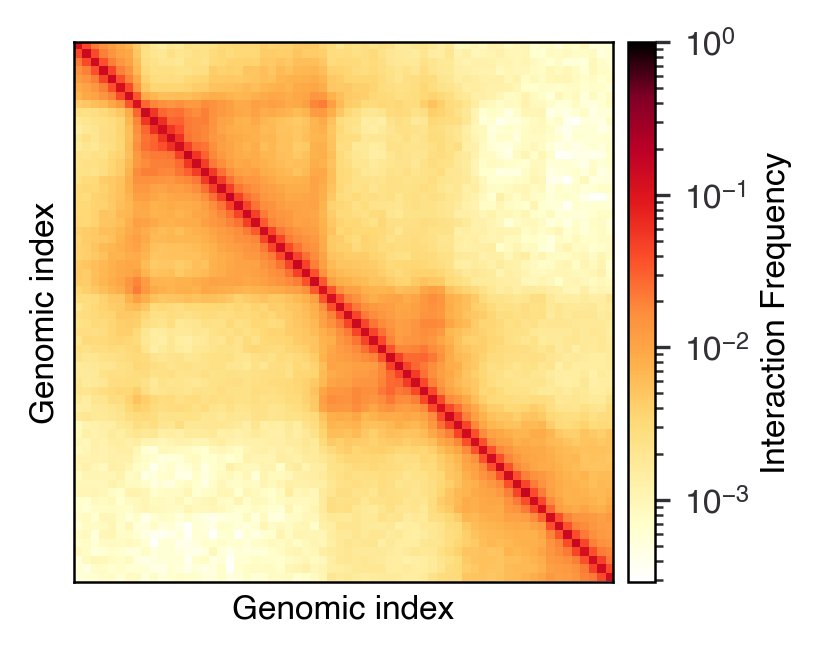

In [29]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(2.5,2.5))
exp_hic_map.plot(fig=fig,ax=ax)
if force_replot:
    fig.savefig(save_directory + f'experimental_hic_{chrom}_{region_idx}.pdf');#f'hic_{timestep}.pdf');

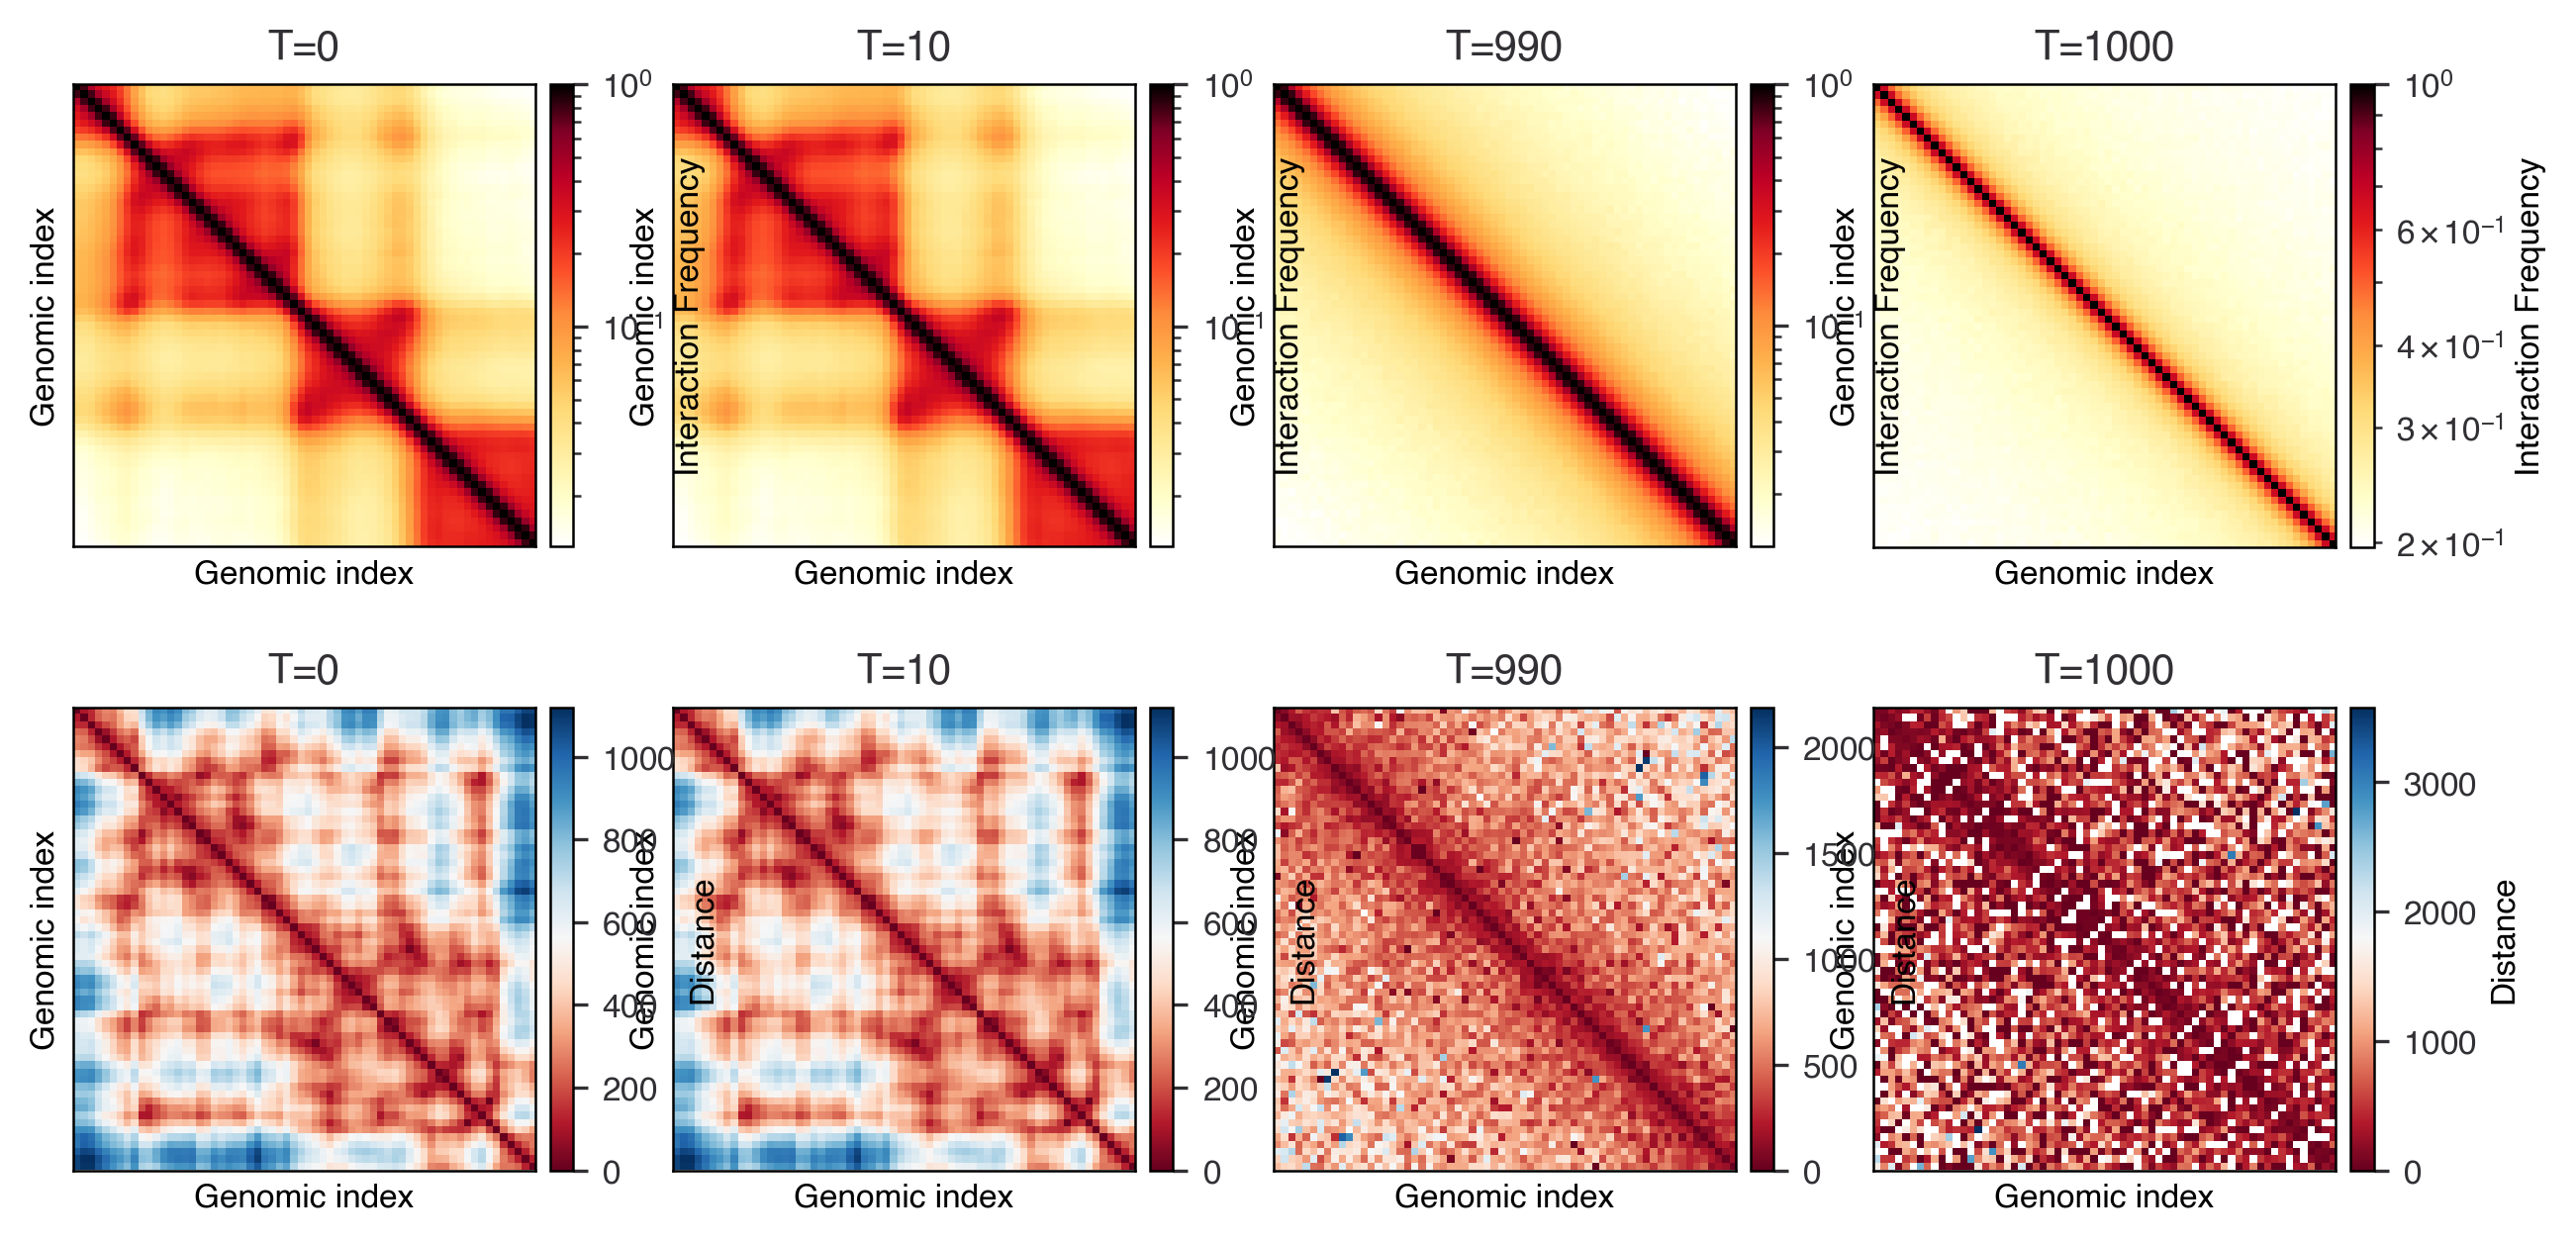

In [30]:
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(10,5))

for i,T in enumerate([0,10,990,1000]):
    ax = axes[0][i]
    all_hic_maps[T].plot(fig=fig,ax=ax)
    ax.set_title(f'T={T}')

    ax = axes[1][i]
    specific_conformation[T].plot(fig=fig,ax=ax)
    ax.set_title(f'T={T}')

Save dcd file for 3D conformation

In [44]:
temp = specific_conformation[0].coordinates
temp._values/= 100 # back to reduced units for VMD
temp.trajectory.save_dcd(
    save_directory + f'specific_conformation_{chrom}_{region_idx}_{specific_conformation_guidance_idx}_{specific_conformation_idx}.dcd'
)
del temp 